In [1]:
from   data_viz_helpers import *
import json
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import ScraperFC as sfc

In [2]:
col_names = ['desc', 'cross_y', 'x', 'y', 'end_x', 'end_y']
home_def_to_mid = pd.DataFrame(columns=col_names)
home_mid_to_att = pd.DataFrame(columns=col_names)
away_def_to_mid = pd.DataFrame(columns=col_names)
away_mid_to_att = pd.DataFrame(columns=col_names)

scraper = sfc.WhoScored()
try:
    match_data = scraper.scrape_match('https://www.whoscored.com/Matches/1602930/Live/International-World-Cup-Qualification-UEFA-2021-2022-Portugal-Turkey')
except:
    traceback.print_exc()
scraper.close()

In [3]:
# Get home and away player IDs
home_ids = [player['playerId'] for player in match_data['matchCentreData']['home']['players']]
away_ids = [player['playerId'] for player in match_data['matchCentreData']['away']['players']]

for event in match_data['matchCentreData']['events']:
    event_desc = event['type']['displayName']
    try:
        player_id = event['playerId']
        m = (event['endY']-event['y']) / (event['endX']-event['x'])
        b = event['y'] - m*event['x']
    except KeyError:
        continue
    except ZeroDivisionError:
        continue
    if player_id in home_ids:
        if event['x']<33.3 and event['endX']>33.3 and event['endX']<66.6 and event_desc!='OffsidePass':
            home_def_to_mid = home_def_to_mid.append(
                pd.Series({
                    'desc': event_desc,
                    'cross_y': m*33.3 + b,
                    'x': event['x'],
                    'y': event['y'],
                    'end_x': event['endX'],
                    'end_y': event['endY']
                }),
                ignore_index=True
            )
        # transition from middle third to attacking third
        elif event['x']<66.6 and event['endX']>66.6 and event['x']>33.3 and event_desc!='OffsidePass':
            home_mid_to_att = home_mid_to_att.append(
                pd.Series({
                    'desc': event_desc,
                    'cross_y': m*66.6 + b,
                    'x': event['x'],
                    'y': event['y'],
                    'end_x': event['endX'],
                    'end_y': event['endY']
                }),
                ignore_index=True
            )
    elif player_id in away_ids:
        if event['x']<33.3 and event['endX']>33.3 and event['endX']<66.6 and event_desc!='OffsidePass':
            away_def_to_mid = away_def_to_mid.append(
                pd.Series({
                    'desc': event_desc,
                    'cross_y': m*33.3 + b,
                    'x': event['x'],
                    'y': event['y'],
                    'end_x': event['endX'],
                    'end_y': event['endY']
                }),
                ignore_index=True
                )
        # transition from middle third to attacking third
        elif event['x']<66.6 and event['endX']>66.6 and event['x']>33.3 and event_desc!='OffsidePass':
            away_mid_to_att = away_mid_to_att.append(
                pd.Series({
                    'desc': event_desc,
                    'cross_y': m*66.6 + b,
                    'x': event['x'],
                    'y': event['y'],
                    'end_x': event['endX'],
                    'end_y': event['endY']
                }),
                ignore_index=True
            )

/var/folders/_4/l7p0flmx0mb9f_729fk_68n00000gn/T/ipykernel_22509/4215545122.py:56: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  away_mid_to_att = away_mid_to_att.append(
/var/folders/_4/l7p0flmx0mb9f_729fk_68n00000gn/T/ipykernel_22509/4215545122.py:43: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  away_def_to_mid = away_def_to_mid.append(
/var/folders/_4/l7p0flmx0mb9f_729fk_68n00000gn/T/ipykernel_22509/4215545122.py:17: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  home_def_to_mid = home_def_to_mid.append(
/var/folders/_4/l7p0flmx0mb9f_729fk_68n00000gn/T/ipykernel_22509/4215545122.py:30: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  ho

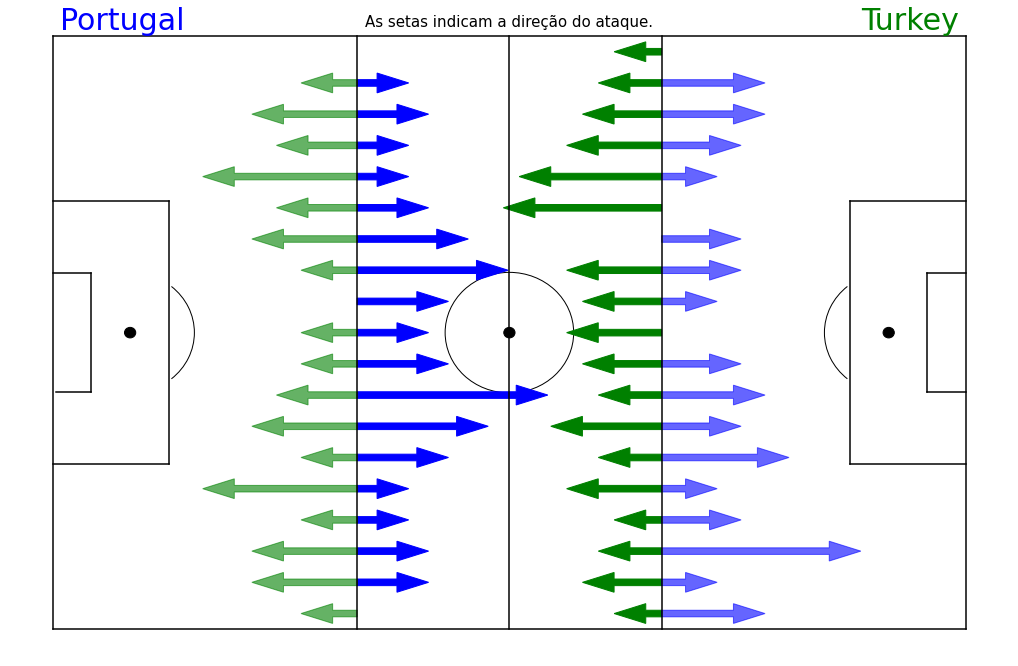

In [4]:
n_bins = 20
bins = np.linspace(0,100,n_bins)
width = 1
dx_mult = 700
fig, ax = plt.subplots(figsize=[18,12])
ax = plot_field(ax)

# Labels
ax.set_title('As setas indicam a direção do ataque.', y=0.96, fontsize=15)
ax.text(
    1, 91, 
    match_data['matchCentreData']['home']['name'], 
    fontsize=30, 
    color='blue'
)
ax.text(
    129, 91, 
    match_data['matchCentreData']['away']['name'], 
    fontsize=30, 
    color='green',
    horizontalalignment='right'
)

# Out of defensive third
ax.plot([130/3, 130/3], [0, 90], color='black')
# Create histograms bins and values for each bin
vals, _ = np.histogram(home_def_to_mid['cross_y'], bins=bins, density=True)
# Plot the bins as arrows indicating the attacking direction. Use the values as the lengths
for i in range(len(vals)):
    if vals[i] == 0:
        continue
    ax.arrow(
        x=130/3, y=(bins[i]+bins[1]/2) * 90/100, 
        dx=vals[i]*dx_mult, dy=0, 
        width=width, color='blue'
    )
# Now do it for away team
vals, _ = np.histogram(away_def_to_mid['cross_y'], bins=bins, density=True)
for i in range(len(vals)):
    if vals[i] == 0:
        continue
    ax.arrow(
        x=130*2/3, 
        # Need to flip and shift away team y values to get them going the other way
        y=(-bins[i]+100-bins[1]/2) * 90/100, 
        dx=-vals[i]*dx_mult, dy=0, 
        width=width, color='green'
    )
    
# Into attacking third
ax.plot([130*2/3, 130*2/3], [0, 90], color='black')
vals, _ = np.histogram(home_mid_to_att['cross_y'], bins=bins, density=True)
for i in range(len(vals)):
    if vals[i] == 0:
        continue
    ax.arrow(
        x=130*2/3, y=(bins[i]+bins[1]/2) * 90/100, 
        dx=vals[i]*dx_mult, dy=0, 
        width=width, color='blue', alpha=0.6
    )
# Now do it for away team
vals, _ = np.histogram(away_mid_to_att['cross_y'], bins=bins, density=True)
for i in range(len(vals)):
    if vals[i] == 0:
        continue
    ax.arrow(
        x=130/3, y=(-bins[i]+100-bins[1]/2) * 90/100, 
        dx=-vals[i]*dx_mult, dy=0, 
        width=width, color='green', alpha=0.6
    )

plt.show()

#save figure
fig.savefig('ataques último terço.png', dpi=600)

In [5]:
# This is code to scrape transitions between thirds for entire seasons of match data from WhoScored

# for filename in ['EPL_2021_match_data.json']:
#     # Read data from JSON file
#     with open(filename, 'r') as f:
#         data = json.loads(f.read())
#     print('{} loaded.'.format(filename))
    
#     # Parse out the events that are assists
#     i = 0
#     for item in data.items():
#         i += 1
#         print('{}/{}'.format(i, len(data.items())), end='\r')
        
#         for event in item[1]['matchCentreData']['events']:
#             event_desc = event['type']['displayName']
            
#             try:
#                 m = (event['endY']-event['y']) / (event['endX']-event['x'])
#                 b = event['y'] - m*event['x']
#             except KeyError:
#                 continue
#             except ZeroDivisionError:
#                 continue
                
#             # transition from def third to middle third
#             if event['x']<33.3 and event['endX']>33.3 and event['endX']<66.6 and event_desc!='OffsidePass':
#                 def_to_mid = def_to_mid.append(
#                     pd.Series({
#                         'desc': event_desc,
#                         'cross_y': m*33.3 + b,
#                         'x': event['x'],
#                         'y': event['y'],
#                         'end_x': event['endX'],
#                         'end_y': event['endY']
#                     }),
#                     ignore_index=True
#                 )
#             # transition from middle third to attacking third
#             elif event['x']<66.6 and event['endX']>66.6 and event['x']>33.3 and event_desc!='OffsidePass':
#                 mid_to_att = mid_to_att.append(
#                     pd.Series({
#                         'desc': event_desc,
#                         'cross_y': m*66.6 + b,
#                         'x': event['x'],
#                         'y': event['y'],
#                         'end_x': event['endX'],
#                         'end_y': event['endY']
#                     }),
#                     ignore_index=True
#                 )
                
#     print('Events from {} parsed.'.format(filename))
#     del data